# Project: Decoding Molecules From Fingerprints.
## Group Members:
### Qi Chen, e-mail: gusqichr@student.gu.se
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
***

In [11]:
import os
import pandas as pd
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
import numpy as np
from joblib import Parallel, delayed
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
import numpy
from PIL import Image
import subprocess
from rdkit.Chem import AllChem
from typing import List, Tuple
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

### Define directories
***

In [12]:
# Set user directory
USER_DIR = os.path.expanduser('~')

# Set the project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Define the input and output directories
INPUT_DIR = os.path.join(PROJECT_ROOT, 'data/bit_flipping_nn')



### Load Parecoxib Data
***

In [13]:
# Read COX2_SMILES.csv
parecoxib_df = pd.read_parquet(os.path.join(INPUT_DIR, 'parecoxib_flipped_df.parquet'))
print(f"Parecoxib shape: {parecoxib_df.shape}")


Parecoxib shape: (2048, 9)


In [14]:
parecoxib_df.head()

,title,SMILES,FingerprintBits,SparseFingerprintBits,FingerprintBitsFlipped,SparseFingerprintBitsFlipped,FlippedBitPosition,Converted_SMILES,Device_Used
0,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",2047,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda
1,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",2046,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda
2,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",2045,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda
3,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",2044,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda
4,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",2043,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda


### Tanimoto Similarity
***

In [15]:
# Define a function to calculate Tanimoto similarity with debugging
def calculate_tanimoto_safe(smiles1, smiles2):
    try:
        # Skip if either SMILES is marked as 'Invalid SMILES string'
        if smiles1 == 'Invalid SMILES string' or smiles2 == 'Invalid SMILES string':
            return None
        
        # Convert SMILES to molecule objects
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        
        # Debugging information
        if mol1 is None:
            print(f"Failed to parse SMILES1: {smiles1}")
        if mol2 is None:
            print(f"Failed to parse SMILES2: {smiles2}")
        
        # Skip if either molecule failed to parse
        if mol1 is None or mol2 is None:
            return None
        
        # Generate fingerprints for Tanimoto calculation
        morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)
        fp1 = morgan_gen.GetFingerprint(mol1)
        fp2 = morgan_gen.GetFingerprint(mol2)
        
        # Debugging information
        if fp1 is None or fp2 is None:
            print(f"Failed to generate fingerprints for SMILES1: {smiles1}, SMILES2: {smiles2}")
        
        # Calculate Tanimoto similarity
        return TanimotoSimilarity(fp1, fp2)
    
    except Exception as e:
        # Print the exception to help diagnose
        print(f"Error calculating Tanimoto similarity: {e}")
        return None

In [16]:
parecoxib_df['Tanimoto'] = parecoxib_df.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Converted_SMILES']), axis=1)

In [18]:
parecoxib_df.head()

,title,SMILES,FingerprintBits,SparseFingerprintBits,FingerprintBitsFlipped,SparseFingerprintBitsFlipped,FlippedBitPosition,Converted_SMILES,Device_Used,Tanimoto
0,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",2047,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda,1.0
1,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",2046,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda,1.0
2,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",2045,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda,1.0
3,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",2044,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda,1.0
4,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",2043,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda,1.0


In [20]:
average_similarity = parecoxib_df['Tanimoto'].mean()
print(f"Average Tanimoto Similarity: {average_similarity}")

Average Tanimoto Similarity: 0.9995914251117113


In [21]:
tanimoto_matches = (parecoxib_df['Tanimoto'] == 1.0).sum()
total_compounds = len(parecoxib_df)
print(f"Tanimoto Accuracy: {tanimoto_matches / total_compounds:.2%}")

Tanimoto Accuracy: 99.66%


In [22]:
def compare_canonical_smiles(smiles1, smiles2):
    try:
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        
        if mol1 is None:
            return {'match': False, 'reason': f"Invalid SMILES 1: {smiles1}"}
        if mol2 is None:
            return {'match': False, 'reason': f"Invalid SMILES 2: {smiles2}"}
        
        canonical_smiles1 = Chem.MolToSmiles(mol1, isomericSmiles=True, canonical=True)
        canonical_smiles2 = Chem.MolToSmiles(mol2, isomericSmiles=True, canonical=True)
        
        if canonical_smiles1 == canonical_smiles2:
            return {'match': True, 'canonical_smiles': canonical_smiles1}
        else:
            return {'match': False, 'reason': "Canonical SMILES do not match",
                    'canonical_smiles1': canonical_smiles1,
                    'canonical_smiles2': canonical_smiles2}
    except Exception as e:
        return {'match': False, 'reason': f"Error during comparison: {str(e)}"}

In [23]:
parecoxib_df['Canonical_Match'] = parecoxib_df.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Converted_SMILES']), axis=1)

In [26]:
parecoxib_df.tail()


,title,SMILES,FingerprintBits,SparseFingerprintBits,FingerprintBitsFlipped,SparseFingerprintBitsFlipped,FlippedBitPosition,Converted_SMILES,Device_Used,Tanimoto,Canonical_Match
2043,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4, 41, 80, 179, 248, 294, 307, 319, 323, 331,...",4,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda,1.0,"{'match': True, 'canonical_smiles': 'CCC(=O)NS..."
2044,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 41, 80, 179, 248, 294, 307, 319, 323, 331,...",3,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda,1.0,"{'match': True, 'canonical_smiles': 'CCC(=O)NS..."
2045,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 41, 80, 179, 248, 294, 307, 319, 323, 331,...",2,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda,1.0,"{'match': True, 'canonical_smiles': 'CCC(=O)NS..."
2046,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 41, 80, 179, 248, 294, 307, 319, 323, 331,...",1,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda,1.0,"{'match': True, 'canonical_smiles': 'CCC(=O)NS..."
2047,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 41, 80, 179, 248, 294, 307, 319, 323, 331,...",0,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1,cuda,1.0,"{'match': True, 'canonical_smiles': 'CCC(=O)NS..."


In [25]:
canonical_matches = parecoxib_df['Canonical_Match'].apply(lambda x: x['match']).sum()
print(f"Canonical SMILES Match Accuracy: {canonical_matches / total_compounds:.2%}")
print(f"Number of Canonical SMILES not matching: {parecoxib_df['Canonical_Match'].apply(lambda x: not x['match']).sum()}")
print(f"Number of Canonical SMILES matching: {parecoxib_df['Canonical_Match'].apply(lambda x: x['match']).sum()}")

Canonical SMILES Match Accuracy: 99.37%
Number of Canonical SMILES not matching: 13
Number of Canonical SMILES matching: 2035


In [31]:
raw_smiles_matches = parecoxib_df.apply(lambda row: row['SMILES'] == row['Converted_SMILES'], axis=1)
print(f"Raw SMILES Match Accuracy: {raw_smiles_matches.mean():.2%}")
print(f"Number of Raw SMILES not matching: {(~raw_smiles_matches).sum()}")
print(f"Number of Raw SMILES matching: {raw_smiles_matches.sum()}")


Raw SMILES Match Accuracy: 0.00%
Number of Raw SMILES not matching: 2048
Number of Raw SMILES matching: 0


### Plot the nearest neighbors
***

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from sklearn.manifold import MDS

def generate_fingerprints(smiles_list):
    """Generate Morgan fingerprints for a list of SMILES strings."""
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in mols]
    return fps

def calculate_similarity_matrix(fps):
    """Calculate Tanimoto similarity matrix for a list of fingerprints."""
    n = len(fps)
    similarity_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            similarity_matrix[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])
    return similarity_matrix

def plot_mds_similarity(df, title_column='title', smiles_column='SMILES', 
                        converted_smiles_column='Converted_SMILES'):
    """Plot MDS similarity for molecules in the dataframe with a color bar indicating similarity to the original."""
    # Extract SMILES (original + converted)
    original_smiles = df[smiles_column].iloc[0]  # Assuming all rows have the same original SMILES
    all_smiles = [original_smiles] + df[converted_smiles_column].tolist()

    # Generate fingerprints and calculate similarity matrix
    fps = generate_fingerprints(all_smiles)
    similarity_matrix = calculate_similarity_matrix(fps)

    # Apply MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(1 - similarity_matrix)  # Convert similarity to distance

    # Calculate similarities to the original molecule
    similarities_to_original = similarity_matrix[0, 1:]

    # Plot
    plt.figure(figsize=(14, 10))
    
    # Plot converted SMILES with color indicating similarity to original
    scatter = plt.scatter(coords[1:, 0], coords[1:, 1], c=similarities_to_original, 
                          cmap='viridis', alpha=0.6, s=100)
    
    # Plot original SMILES in red
    plt.scatter(coords[0, 0], coords[0, 1], c='red', s=200, label='Original SMILES', edgecolors='black')

    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Tanimoto Similarity to Original', rotation=270, labelpad=20)

    # Add labels
    for i, smiles in enumerate(all_smiles):
        label = "Original" if i == 0 else f"{df['FlippedBitPosition'].iloc[i-1]}"
        plt.annotate(label, (coords[i, 0], coords[i, 1]), xytext=(5, 5), 
                     textcoords='offset points', fontsize=8)

    plt.title(f"2D Projection of Molecular Similarity for {df[title_column].iloc[0]}")
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.legend()
    plt.tight_layout()
    
    return plt

# Function to process the dataframe and generate the plot
def process_and_plot(df):
    plt = plot_mds_similarity(df)
    plt.show()

# Usage example:
# df = pd.read_parquet('your_processed_file.parquet')
# process_and_plot(df)

[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerator
[00:08:57] DEPRECATION WARNING: please use MorganGenerat

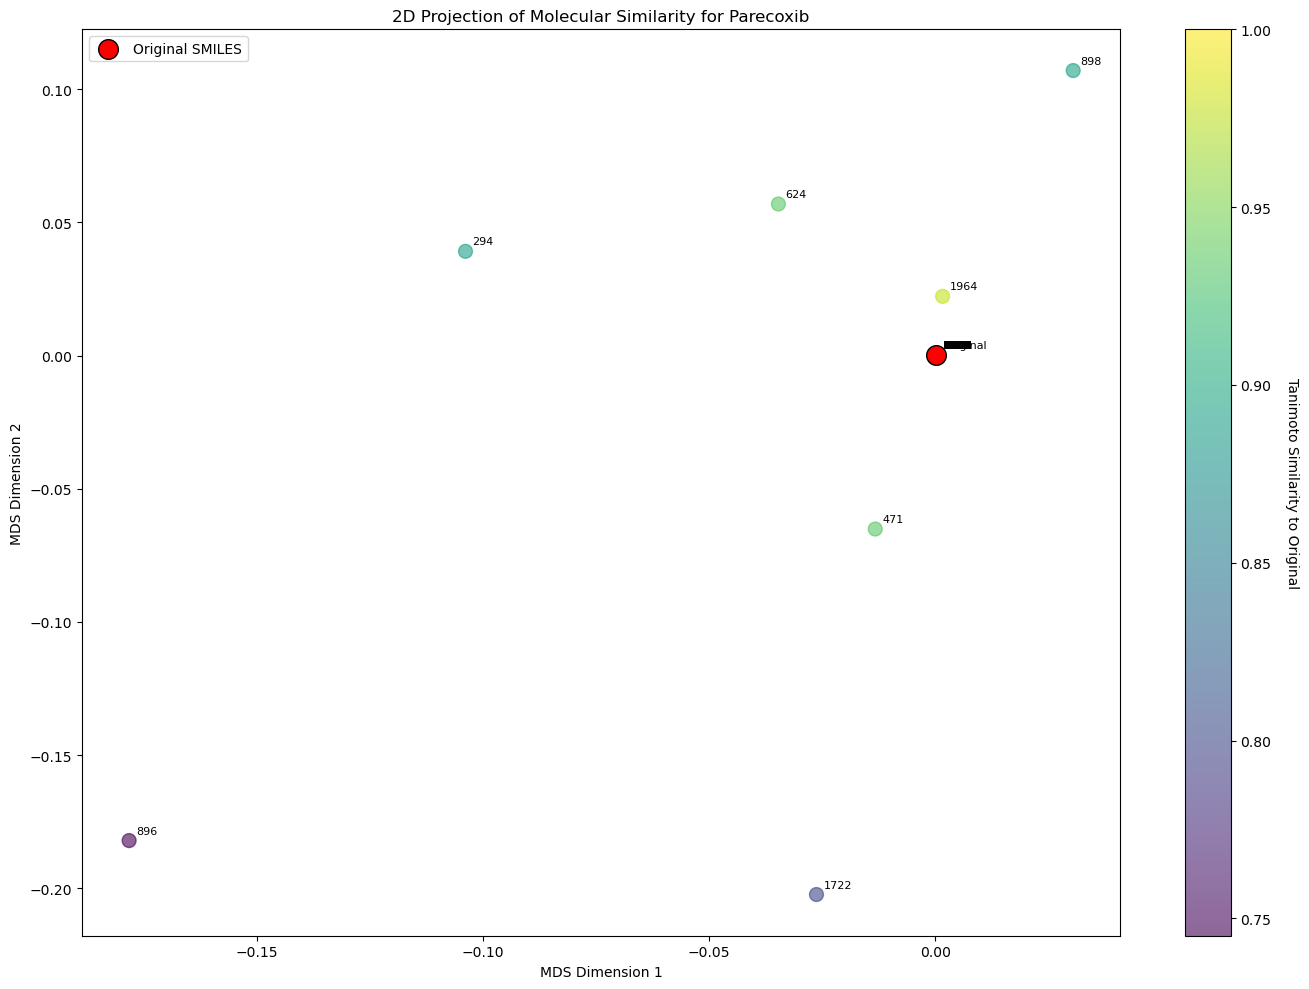

In [39]:
process_and_plot(parecoxib_df)

In [51]:
parecoxib_df[parecoxib_df['FlippedBitPosition'].isin([1964, 1722, 896, 471, 294, 624, 898])].sort_values(by='Tanimoto', ascending=False)


,title,SMILES,FingerprintBits,SparseFingerprintBits,FingerprintBitsFlipped,SparseFingerprintBitsFlipped,FlippedBitPosition,Converted_SMILES,Device_Used,Tanimoto,Canonical_Match
83,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",1964,CCC(=O)NS(=O)(=O)c1ccc(-c2ccc(-c3c(-c4ccc(-c5c...,cuda,0.977778,"{'match': False, 'reason': 'Canonical SMILES d..."
1576,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",471,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3noc(C)c3-c3cccc...,cuda,0.933333,"{'match': False, 'reason': 'Canonical SMILES d..."
1423,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",624,CCC(=O)NS(=O)(=O)c1ccc(-c2noc(C)c2-c2c(-c3cccc...,cuda,0.933333,"{'match': False, 'reason': 'Canonical SMILES d..."
1753,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 307, 319, 323, 331, 350, 36...",294,Cc1onc(-c2ccccc2)c1-c1ccc(S(=O)(=O)NC(=O)CC(=O...,cuda,0.888889,"{'match': False, 'reason': 'Canonical SMILES d..."
1149,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",898,Cc1onc(-c2ccccc2)c1-c1ccc(S(=O)(=O)NC(=O)CC(=O...,cuda,0.888889,"{'match': False, 'reason': 'Canonical SMILES d..."
325,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",1722,CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2-c2c...,cuda,0.795918,"{'match': False, 'reason': 'Canonical SMILES d..."
1151,Parecoxib,CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41 80 179 248 294 307 319 323 331 350 361 378 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 80, 179, 248, 294, 307, 319, 323, 331, 35...",896,CCC(=O)NS(=O)(=O)c1ccc(S(=O)(=O)NC(=O)c2c(-c3c...,cuda,0.745098,"{'match': False, 'reason': 'Canonical SMILES d..."


In [52]:
tanimoto_matches = (parecoxib_df['Tanimoto'] < 0.98).sum()
total_compounds = len(parecoxib_df)
print(f"Tanimoto Accuracy: {tanimoto_matches / total_compounds:.2%}")
print(f"Number of Tanimoto similarity less than 0.98: {tanimoto_matches}")

Tanimoto Accuracy: 0.34%
Number of Tanimoto similarity less than 0.98: 7
